In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


지금까지 살펴본 신경망은 **피드포워드(feed forward)**라는 유형의 신경망이다. 피드포워드란 흐름이 단방향인 신경망을 말한다. 단순한 피드 포워드 신경망에서는 시계열 데이터의 성질(패턴)을 충분히 학습할 수 없다. 그래서 **순환 신경망(Recurrent Neural Network, RNN)**이 등장한다.

## **word2vec을 확률 관점에서 바라보다**

지금까지는 맥락을 항상 좌우 대칭으로 생각해왔다. 이번에는 맥락을 왼쪽 윈도우만으로 한정해보자.

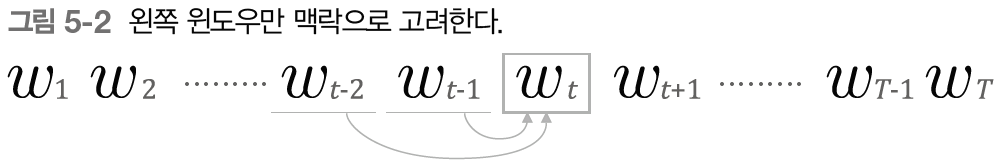

그러면 CBOW 모델이 출력할 확률은 $P(w_t | w_{t-2}, w_{t-1})$ 이다.

따라서 교차 엔트로피 오차에 의해 유도한 결과인 CBOW 모델이 다루는 손실 함수는 다음과 같다.

$$ L = -logP(w_t | w_{t-2}, w_{t-1}) $$

CBOW 모델의 학습으로 수행하는 일은 이 손실함수(정확히는 말뭉치 전체의 손실함수의 총합)를 최소화하는 가중치 매개변수를 찾는 것이다. 이 목적을 위해 학습을 진행하면, 단어의 의미가 인코딩된 '단어의 분산 표현'을 얻을 수 있다.

비대칭 맥락의 확률은 어떤 실용적인 쓰임이 있을까? 여기서 '언어 모델'이 등장한다.

## **언어 모델**

**언어 모델(Language Model)**은 단어 나열에 확률을 부여한다. 예컨대 "you say goodbye"라는 단어 시퀀스에는 높은 확률을 출력하고, "you say good die"에는 낮은 확률을 출력하는 것이 일종의 언어 모델이다.

이 언어모델은 기계 번역과 음성 인식등에 응용될 수 있다. 또한 언어 모델은 새로운 문장을 생성하는 용도로도 이용할 수 있다.

언어 모델을 수식으로 설명해보자. 단어가 $w_1, ..., w_m$ 이라는 순서로 출현할 확률을 $P(w_1, ..., w_m)$으로 나타낸다. 이 확률은 여러 사건이 동시에 일어날 확률이므로 동시 확률이라고 한다.

이 동시 확률 $P(w_1, ..., w_m)$은 사후 확률을 사용하여 다음과 같이 분해하여 쓸 수 있다.

$$P(w_1,...,w_m) = \prod_{t=1}^m P(w_t | w_1, ..., w_{t-1})$$

즉, 동시 확률은 사후 확률의 총 곱으로 나타낼 수 있다. 이는 확률의 **곱셈정리**로부터 유도할 수 있다.

지금까지의 이야기를 정리하면, 우리의 목표는 $P(w_t | w_1, ..., w_{t-1})$이라는 확률을 얻는것이다. 이 확률을 계산할 수 있다면 언어 모델의 동시 확률 $P(w_1, ..., w_m)$을 구할 수 있다.



## **CBOW 모델을 언어 모델로?**

word2vec의 CBOW 모델을 (억지로) 언어 모델에 적용하려면 어떻게 해야 할까? 이는 맥락의 크기를 특정 값으로 한정하여 근사적으로 나타낼 수 있다. 수식으로는 다음과 같다.

$$ P(w_1, ..., w_m) = \prod_{t=1}^m P(w_t | w_1, ... , w_{t-1}) \approx \prod_{t=1}^m P(w_t | w_{t-2}, w_{t-1})$$

맥락을 왼쪽 2개의 단어로 한정한다. 그러면 CBOW 모델에 따라 근사적으로 나타낼 수 있다. 이번 예는 '2층 마르코프 연쇄'라고 부를 수 있다. **마르코프 연쇄(Markov Chain)**란 미래의 상태가 현재 상태에만 의존해 결정되는 것을 말한다. 이 사상의 확률이 '그 직전' N개의 사건에만 의존할 때, 이를 'N층 마르코프 연쇄'라고 한다.

이 맥락의 크기는 임의 길이로 설정할 수 있지만, 결국엔 특정 길이로 '고정'된다. 즉 N개의 맥락 이전에 있는 정보는 무시된다는 것이다.

CBOW 모델의 맥락 크기를 엄청 키운다고 하더라도 CBOW 모델에서는 맥락 안의 단어 순서가 무시된다는 한계가 있다. (CBOW란 continuous bag-of-words의 약어이다)

이상적으로는 맥락의 단어 순서도 고려한 모델이 바람직할 것이다. 맥락의 단어 벡터를 은닉층에서 **연결(concatenate)**하는 방식을 생각할 수도 있지만, 맥락의 크기에 비례해 가중치 매개변수도 늘어나게 된다. 매개변수가 증가한다는 건 환영할 만한 현상이 아니다.

이 문제들을 해결하기 위해서 등장하는 것이 순환 신경망, 즉 RNN이다. RNN은 맥락이 아무리 길더라도 그 맥락의 정보를 기억하는 매커니즘을 갖고 있다. 따라서 RNN을 사용하면 아무리 긴 시계열 데이터에라도 대응할 수 있다.

## **순환하는 신경망**

순환하기 위해서는 '닫힌 경로', 혹은 '순환하는 경로'가 존재해야 데이터가 같은 장소를 반복해 왕래할 수 있다. 그리고 데이터가 순환하면서 정보가 끊임없이 갱신된다.

RNN의 특징은 순환하는 경로 (닫힌 경로)가 있다는 것이다. 이 순환 경로를 따라 데이터는 끊임없이 순환할 수 있다. 그리고 데이터가 순환되기 때문에 과거의 정보를 기억하는 동시에 최신 데이터로 갱신될 수 있다.

그림으로 RNN 계층을 확인해보자.

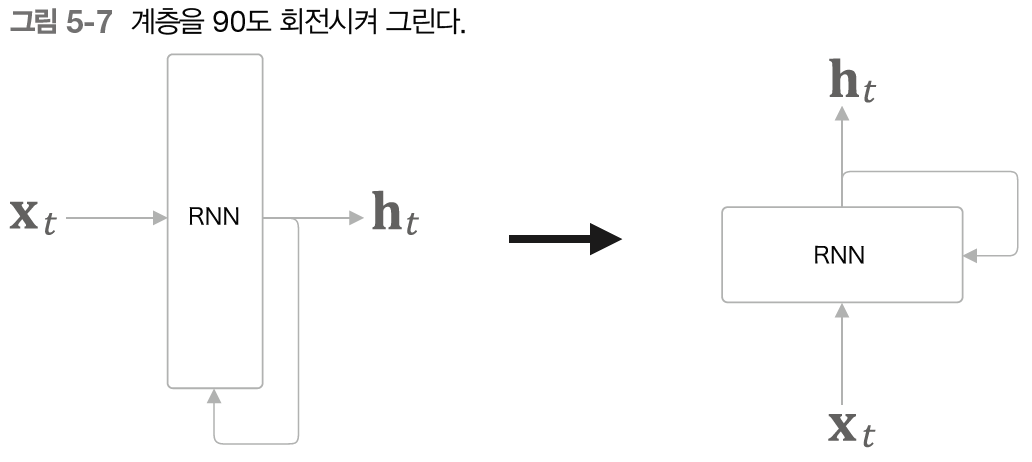

## **순환 구조 펼치기**

RNN의 순환 구조는 지금까지의 신경망에는 존재하지 않던 구조이지만, 순환 구조를 펼치면 친숙한 신경망으로 '변신'시킬수 있다. 그림으로 확인해보자.

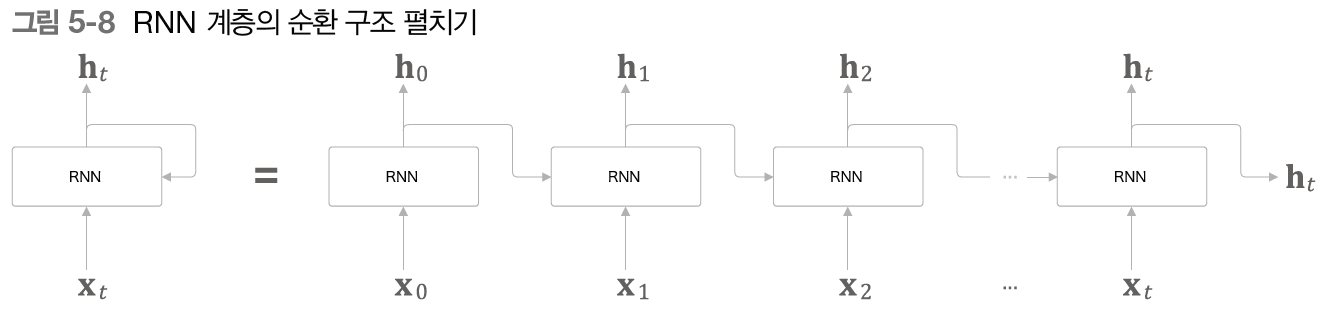

펼쳐보니 지금까지 본 피드포워드 신경망과  같은 구조이다. 하지만 위 그림의 다수의 RNN 계층 모두가 실제로는 '같은 계층'인 것이 지금까지의 신경망과는 다르다. 각 시각의 RNN 계층은 그 계층으로의 입력과 1개 전의 RNN 계층으로부터의 출력을 받는다. 그리고 이 두 정보를 바탕으로 현 시각의 출력을 계산한다. 이때 계산의 수식은 다음과 같다.

$$ h_t = tanh(h_{t-1}W_h + x_tW_x + b) $$

## **BPTT**

앞 서 봤듯이 RNN 계층은 가로로 펼친 신경망으로 간주할 수 있다. 따라서 RNN의 학습도 보통의 신경망과 같은 순서로 진행할 수 있다.

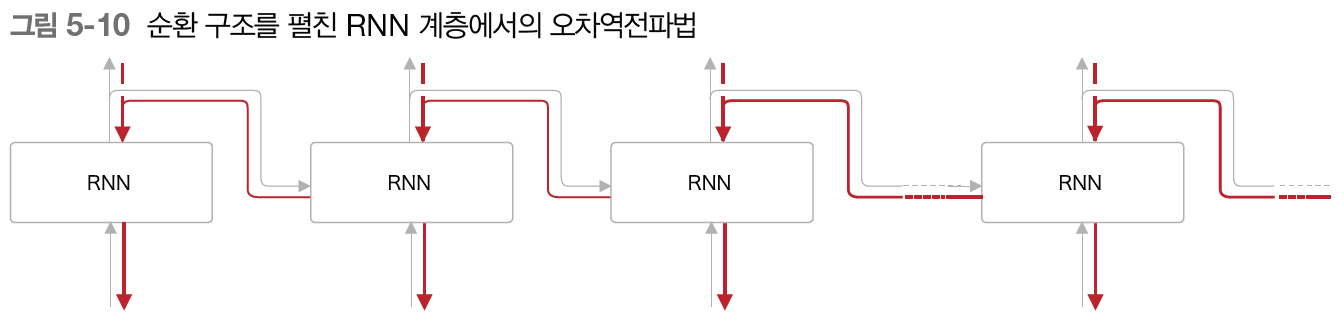

그림에서 보듯, 순환 구조를 펼친 후의 RNN에는 (일반적인) 오차역전파법을 적용할 수 있다. 여기서의 오차역전파법은 '시간 방향으로 펼친 신경망의 오차역전파법'이란 뜻으로 **BPTT(Backpropagation Through Time)**라고 한다.

이 BPTT를 이용하기 전, 긴 시계열 데이터를 학습할 때의 문제를 먼저 해결해야 한다. 시계열 데이터의 시간 크기가 커지는 것에 비례하여 BPTT가 소비하는 컴퓨팅 자원도 증가하는 문제가 생기기 때문이다. 또한, 시간 크기가 커지면 역전파 시의 기울기가 불안정해지는것도 문제이다.

## **Truncated BPTT**

큰 시계열 데이터를 취급할 때, 시간축 방향으로 너무 길어진 신경망을 적당한 지점에서 잘라내어 작은 신경망을 여러 개로 만든다. 이 잘라낸 작은 신경망에서 오차역전파법을 수행한다. 이것이 바로 **Truncated BPTT**라는 기법이다.

하지만 제대로 구현하려면 '역전파'의 연결만 끊어야 한다. 순전파의 연결은 반드시 그대로 유지해야 한다. 즉, 순전파의 흐름은 끊어지지 않고 전파된다. 한편, 역전파의 연결은 적당한 길이로 잘라내, 그 잘라낸 신경망 단위로 학습을 수행한다.

그림으로 확인하면 다음과 같다.

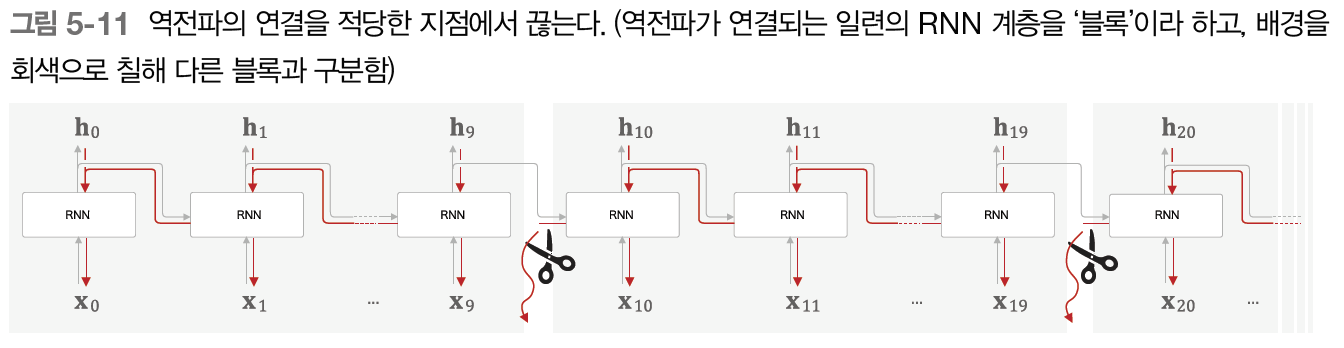

이처럼 역전파의 연결을 잘라버리면, 그보다 미래의 데이터에 대해서는 생각할 필요가 없어진다. 하지만 여기서 반드시 기억할 점은 역전파의 연결은 끊어지지만, 순전파의 연결은 끊어지지 않는다는 점이다. 따라서 RN을 학습시킬 때는 순전파가 연결된다. 데이터를 '순서대로(sequential)' 입력해야 한다는 뜻이다. 이것의 구체적인 의미는 이어서 설명한다.

이어서 Truncated BPTT 방식으로 RNN을 학습시키는 것을 그림으로 확인해보자.

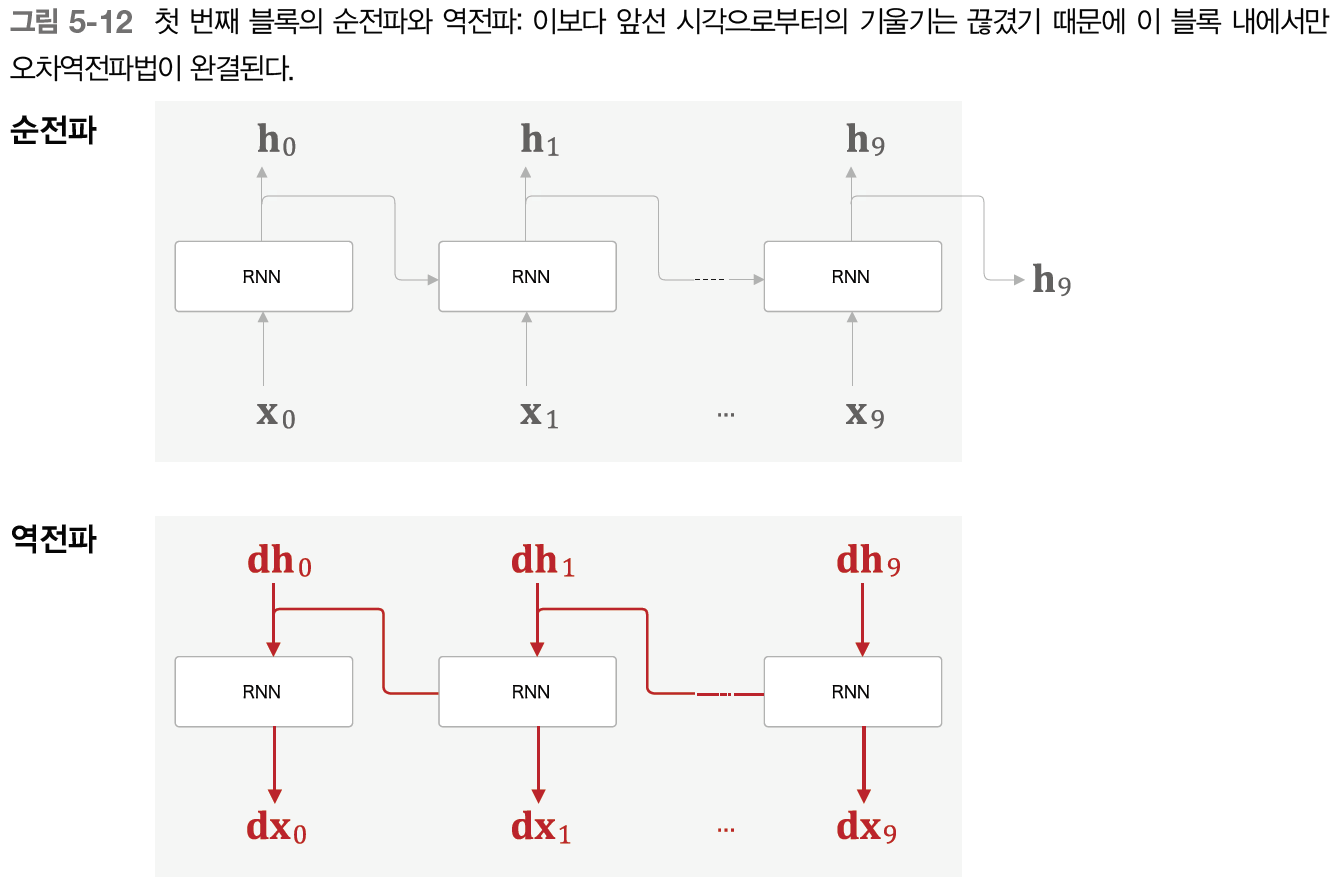

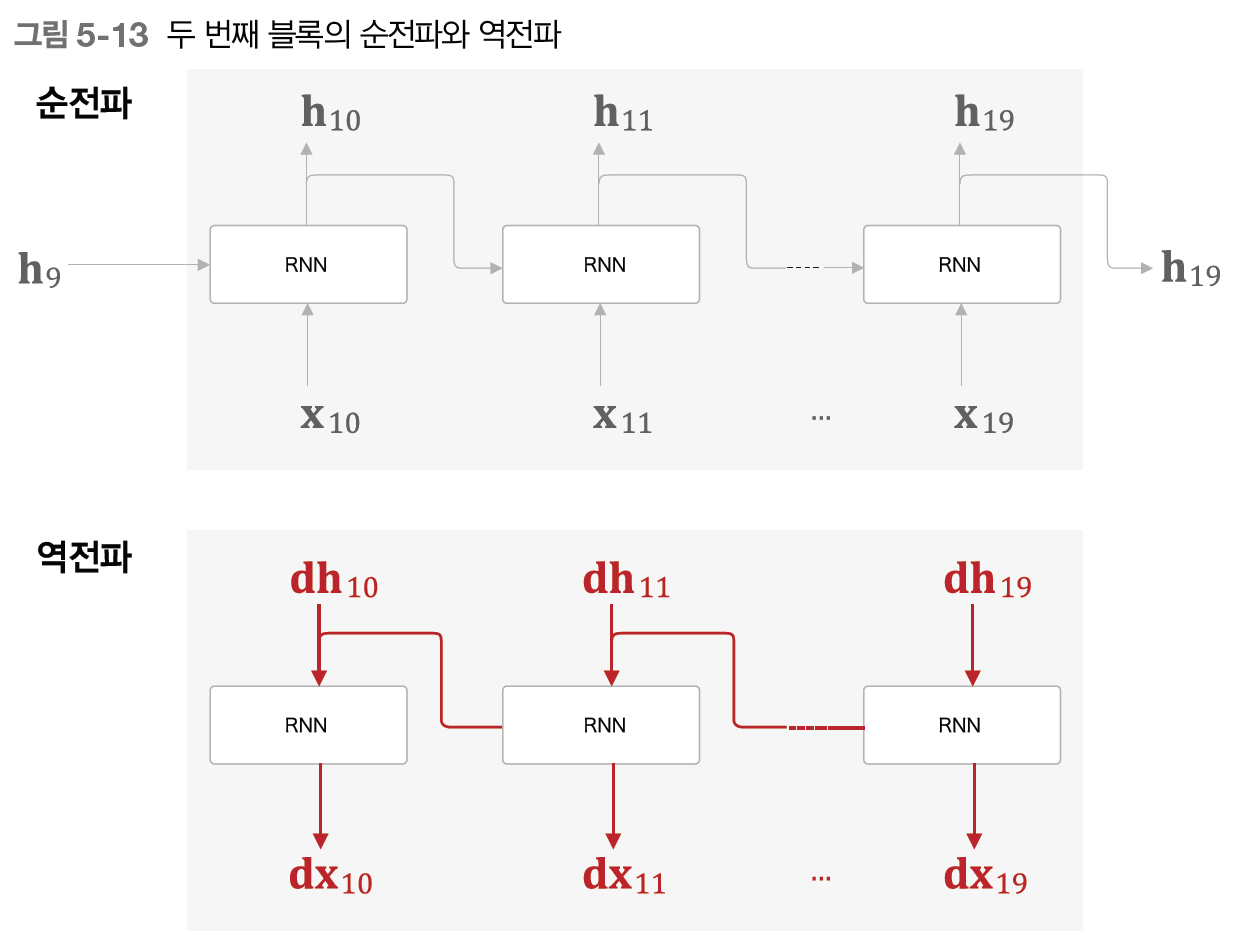

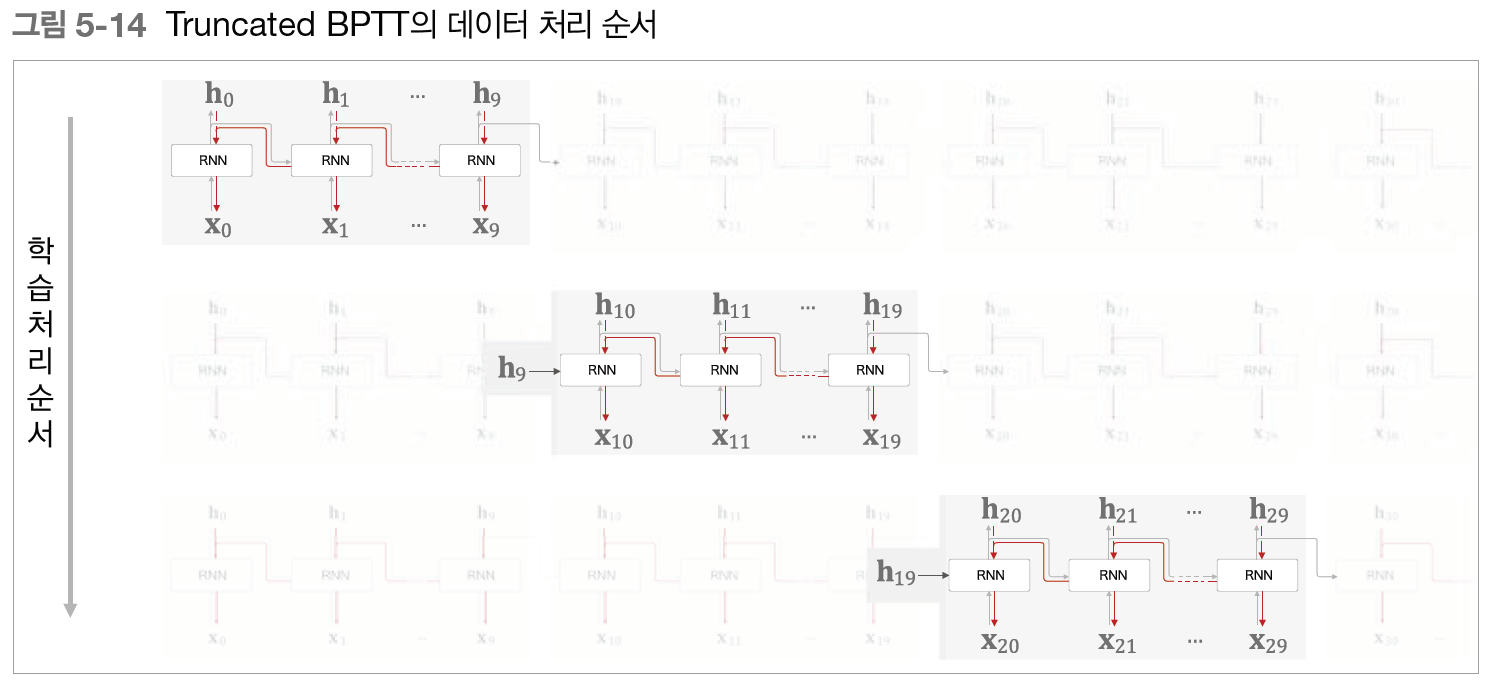

[그림 5-14]처럼 Truncated BPTT에서는 데이터를 순서대로 입력해 학습한다. 이런 식으로 순전파의 연결을 유지하면서 블록 단위로 오차역전파법을 적용할 수 있다.


## **Truncated BPTT의 미니배치 학습**

지금까지의 이야기는 미니배치에 대해선 고려하지 않았다. 하지만 우리는 미니배치 학습을 수행하기 때문에, 원래대로면 구체적인 배치 방식을 고려해 데이터를 순서대로 입력해야 한다. 그렇게 하려면 데이터를 주는 시작 위치를 각 미니배치의 시작 위치로 '옮겨줘야'한다.

'옮긴다'라는 뜻을 설명하기 위해 다음 그림을 제시한다.

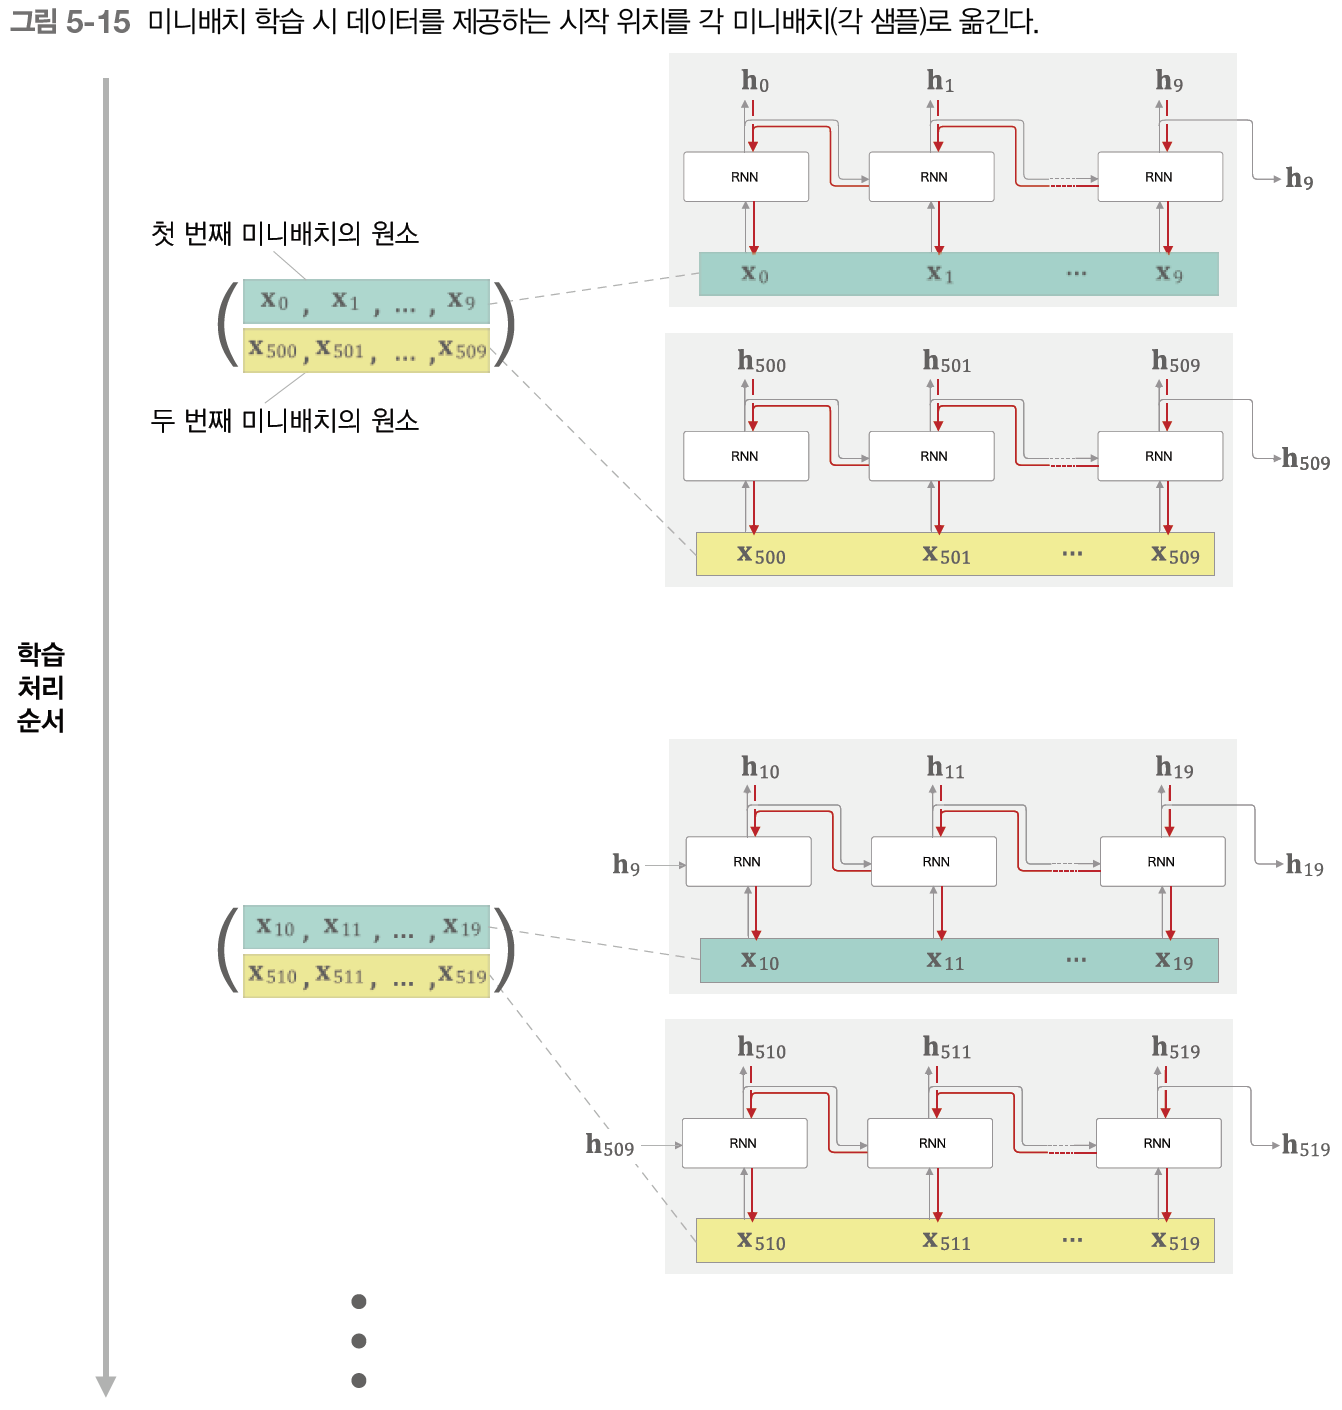

이처럼 미니배치 학습을 수행할 때는 각 미니배치의 시작 위치를 오프셋으로 옮겨준 후 순서대로 제공하면 된다. 또한 데이터를 순서대로 입력하다가 끝에 도달하면 다시 처음부터 입력하도록 한다.

지금까지 본것처럼 Truncated BPTT에서, '데이터를 순서대로 제공하기'와 '미니배치별로 데이터를 제공하는 시작 위치를 옮기기'를 주의해야 한다.

# **RNN 구현**

$T$개 단계분의 작업을 한꺼번에 처리하는 계층을 'TIme RNN 계층'이라 하고, Time RNN 계층 내 에서 한 단계의 작업을 수행하는 계층을 'RNN 계층'이라 한다. (시계열 데이터를 한꺼번에 처리하는 계층에는 앞에 time을 붙인다) 앞으로 할 구현을 그림으로 확인해보자.

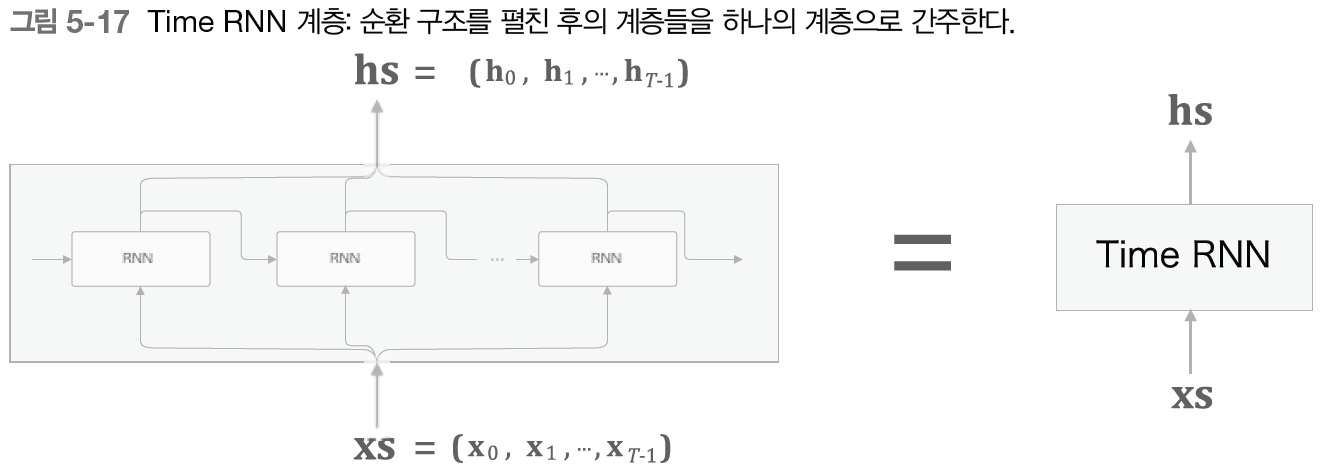

## **RNN 계층 구현**

RNN의 순전파 식은 다음과 같았다.

$$h_t = tanh(h_{t-1}W_h + x_tW_x + b)$$

이를 바탕으로 RNN 클래스를 구현해보자. 이때, RNN계층에서 역전파를 좀 더 이해하기 쉽게 다음 그림을 참고하자.

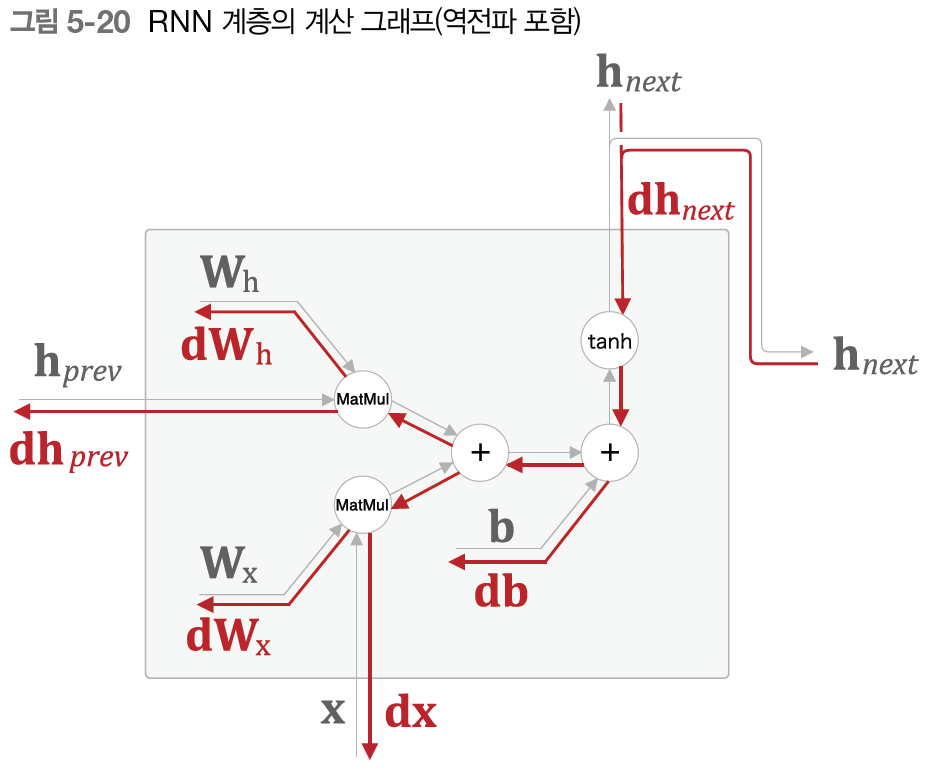

In [4]:
import numpy as np

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

## **Time RNN 계층 구현**

Time RNN 계층은 $T$개의 RNN 계층으로 구성된다. ($T$는 임의의 수) 우리의 TimeRNN 클래스 구현에서, RNN 계층의 은닉 상태 $h$를 인스턴스 변수로 유지한다. 이 변수를 은닉 상태를 '인계'받는 용도로 이용한다. 그림으로 표현하면 다음과 같다.

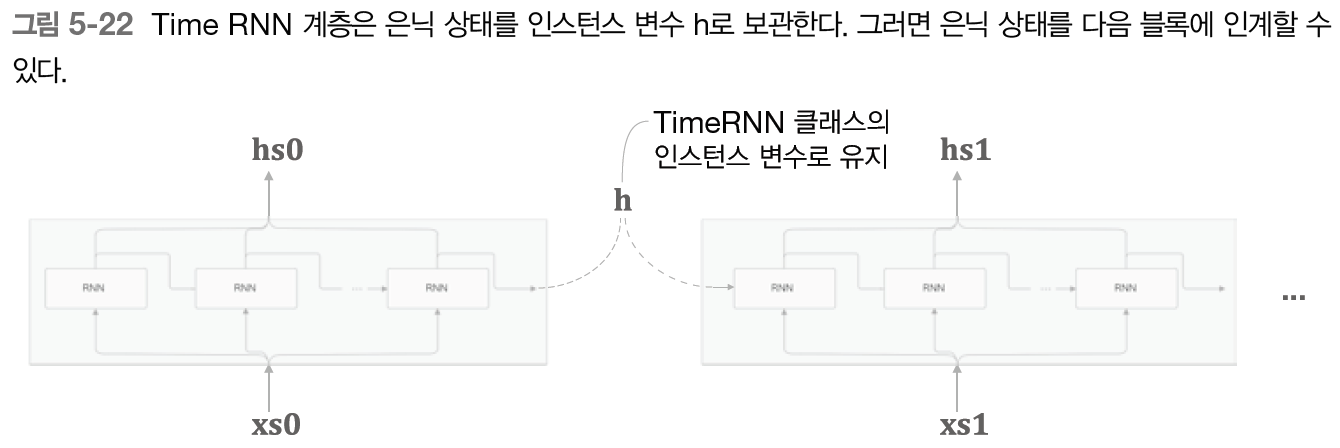

이렇게하면 Time RNN 사용자는 RNN 계층 사이에서 은닉 상태를 '인계하는 작업'을 생각하지 않아도 된다. Time RNN 계층을 코드로 구현해보자.

In [6]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None        # 은닉상태 저장
        self.stateful = stateful            # True 이면 은닉 상태를 유지, 즉 아무리 긴 시계열 데이터라도 계층의 순전파를 끊지 않는다. /  False 이면 은닉 상태를 '영행렬'로 초기화

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

# 역전파 시 RNN 계층에는 합산된 기울기 (dh_t + dh_next)가 입력됨을 주의
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

# **시계열 데이터 처리 계층 구현**

이번 장의 목표는 RNN을 사용하여 '언어 모델'을 구현하는 것이다. 이번 절에서는 시계열 데이터를 처리하는 계층을 몇 개 더 만들어본다. 또한 RNN을 사용한 언어 모델은 영어로 RNN Language Model 이므로 앞으로 RNNLM이라 칭한다.

## **RNNLM의 전체 그림**

그림으로 RNNLM에서 사용되는 신경망을 한번 보고 시작하자. 왼쪽은 RNNLM의 계층 구성이고, 오른쪽에는 이를 시간축으로 펼친 신경망이다.

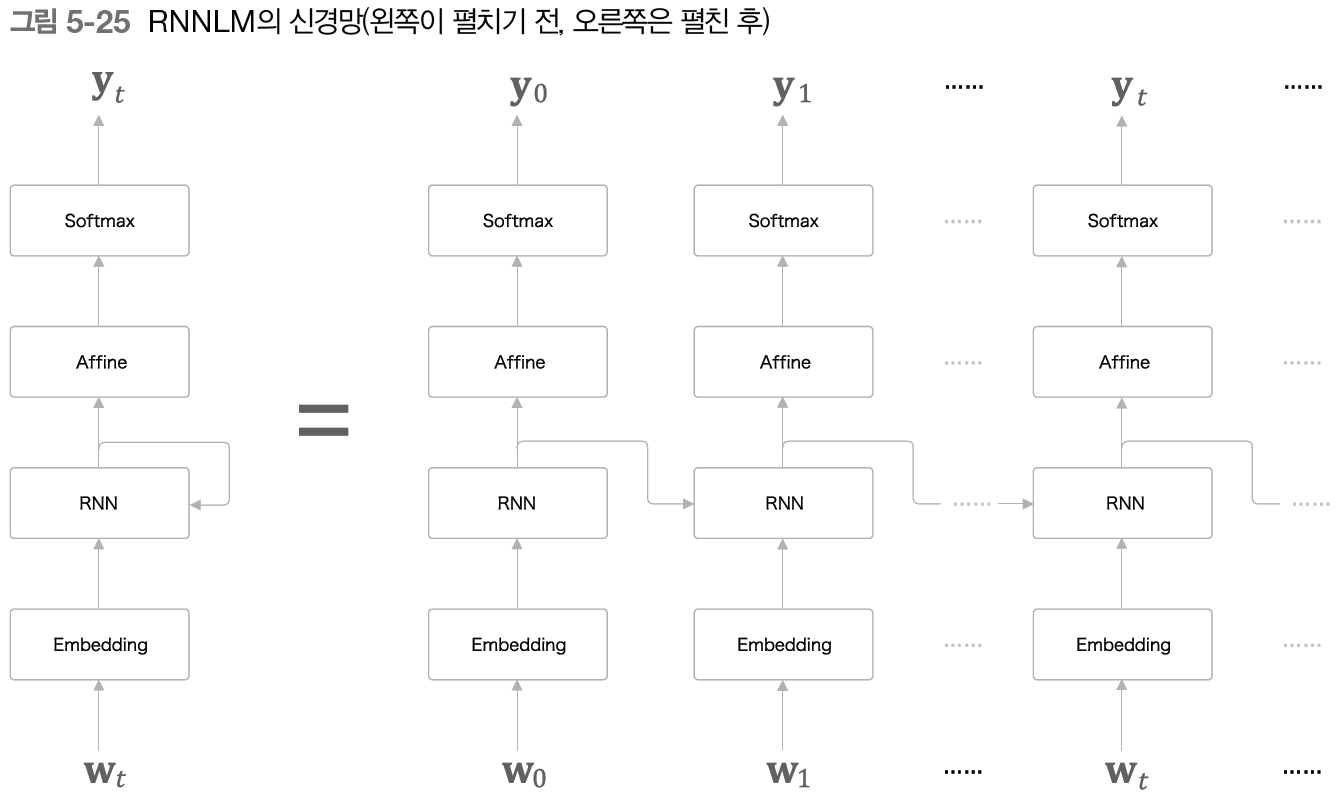

앞에서 계속 예로 들었던 샘플 말뭉치 "You say goodbye and I say hello."가 RNNLM에서 이뤄지는 처리는 다음과 같다.

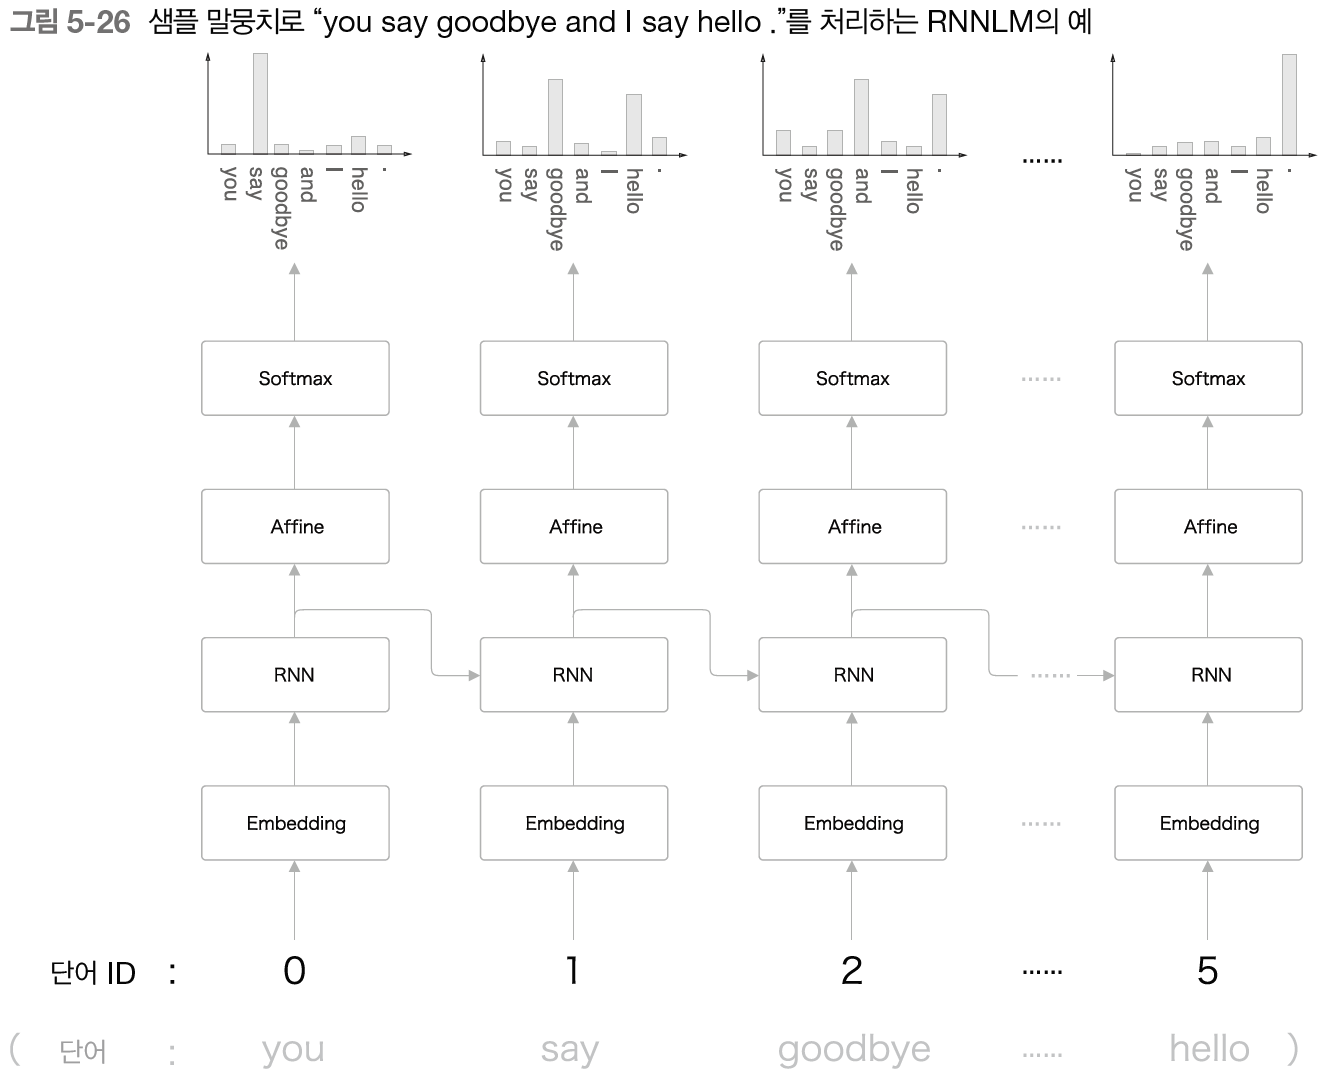

softmax 계층의 첫 단어를 확인하면 "you" 다음에 출현하는 단어가 "say"라는 것을 올바르게 예측 하였다. 다음 단어 "say"를 입력하는 부분에 주목하면, RNN 계층은 "you say"라는 맥락을 '기억'한다. 더 정확하게 말하면, RNN은 "you say"라는 과거의 정보를 응집된 은닉 상태 벡터로 저장해 두고 있다. 그러한 정보를 더 위의 Affine 계층에, 그리고 다음 시각의 RNN 계층에 전달하는 것이 RNN 계층이 하는 일이다. 

## **TIme 계층 구현**

이번 절에서도 시계열 데이터를 한꺼번에 처리하는 계층을 Time Embedding, Time Affine 형태의 이름으로 구현한다. 이 Time OO 계층들을 다 만들면 다음 형태로 구현 된다.

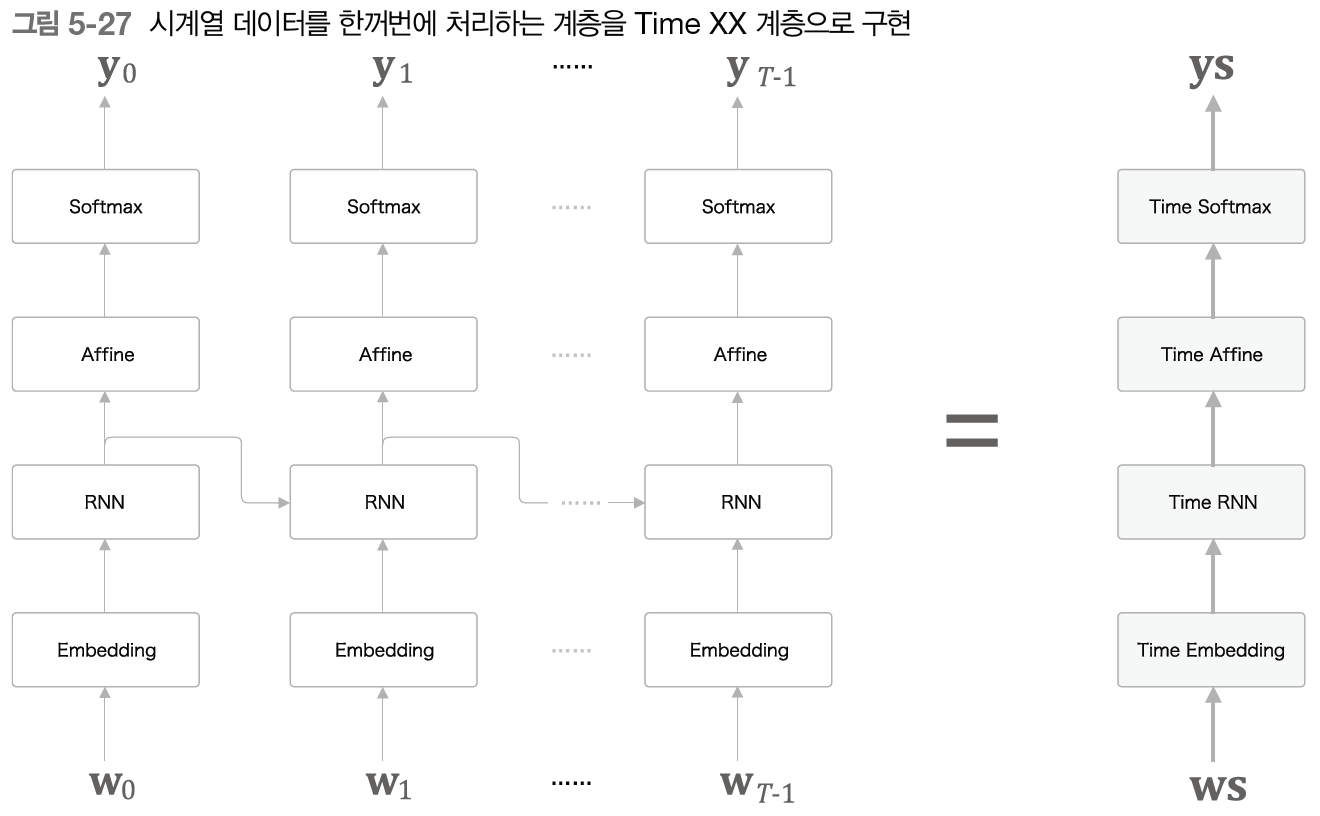

Time Affine 계층은 다음과 같다. TIme Embedding 계층도 다음과 마찬가지이므로 생략한다.

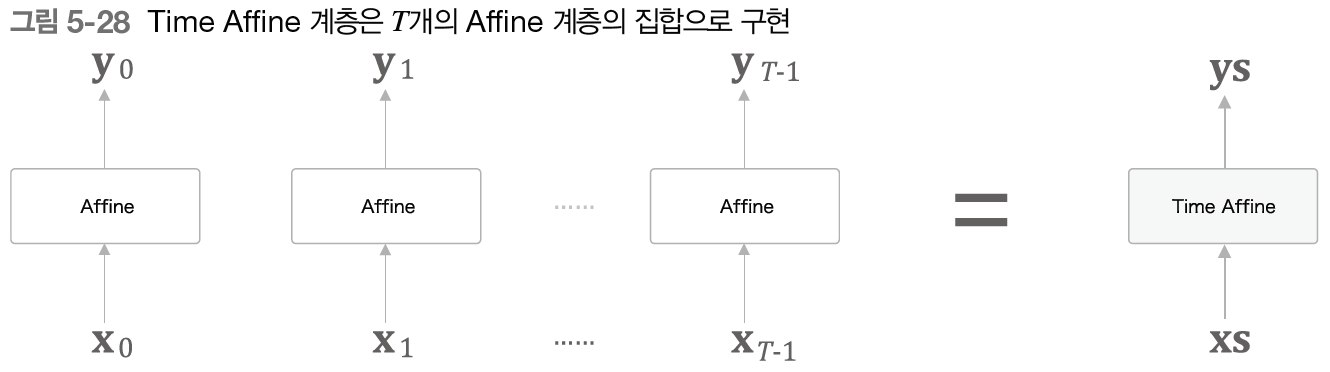

Softmax의 계층을 구현할 때는 손실 오차를 구하는 Cross Entropy Error 계층도 함께 구현한다. 여기서는 다음과 같은 구성의 Time Softmax with Loss 계층으로 구현한다.

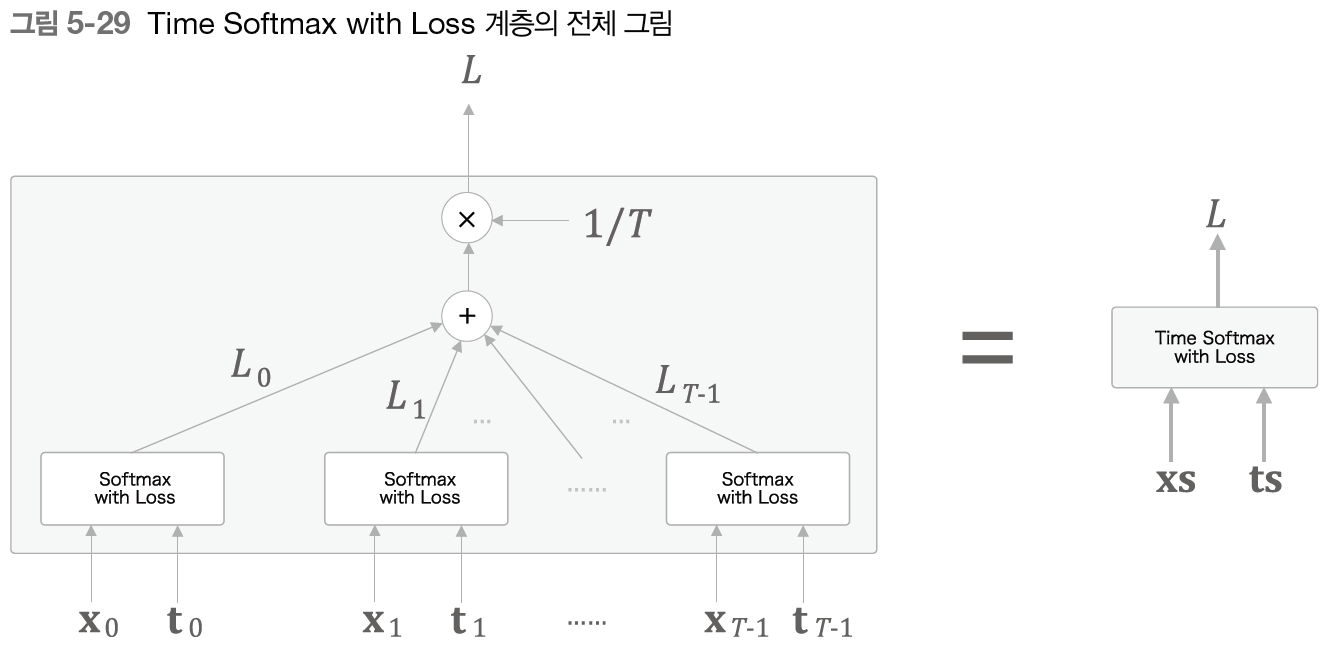

여기서 손실들을 합산해 평균한 값이 최종 손실이 된다. 이때 수행하는 계산의 수식은 다음과 같다.

$$ L = \frac{1}{T}(L_0 + L_1 + ... + L_{T-1}) $$

## **RNNLM 구현**

우리가 구현할 RNNLM에서 사용하는 신경망은 SimpleRnnlm이라는 이름의 클래스로 구현한다. SimpleRnnlm의 계층 구성은 다음과 같다.

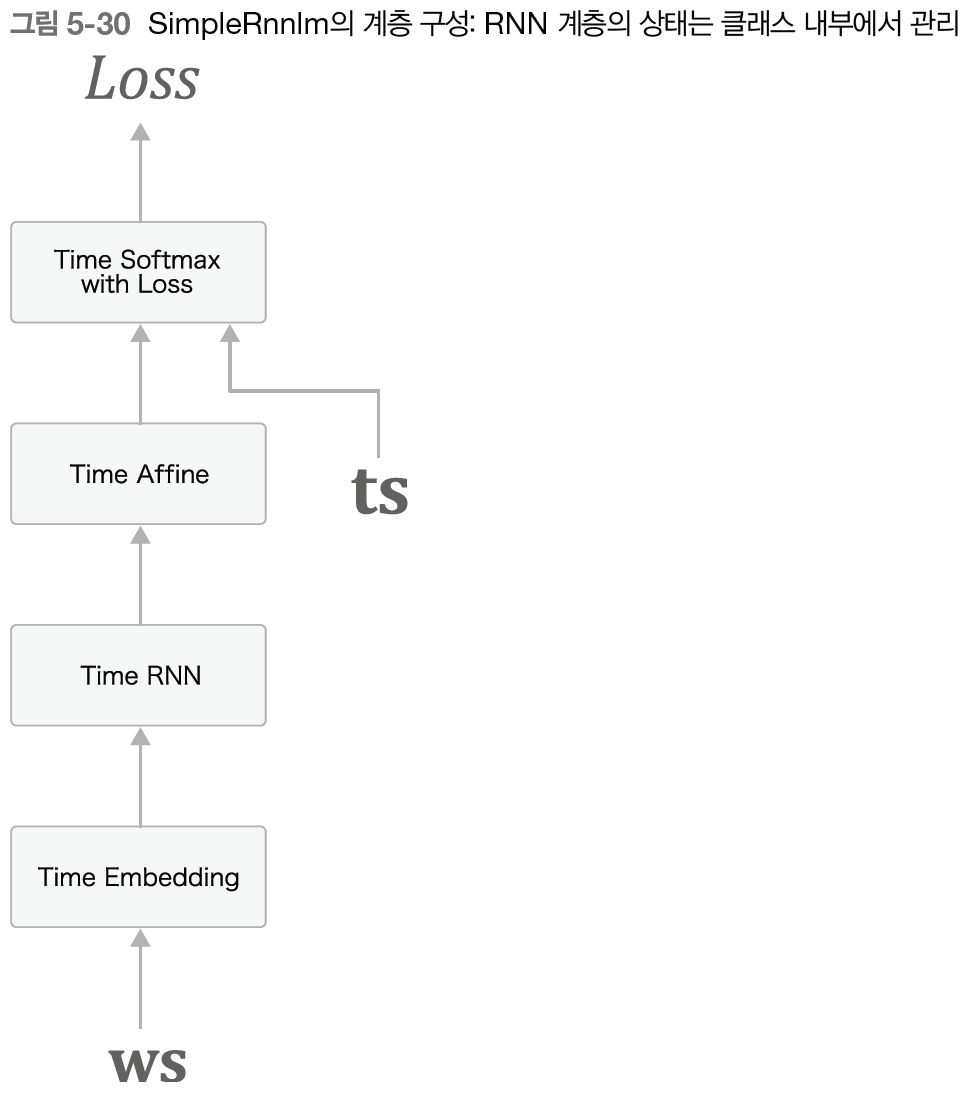

SimpleRnnlm 클래스는 4개의 Time 계층을 쌓은 신경망이다. 코드로 구현하면 다음과 같다.

In [7]:
path = '/content/drive/MyDrive/밑바닥부터시작하는딥러닝2/deep-learning-from-scratch-2-master'

import sys
sys.path.append(path)
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화 --> Xavier 초깃값 사용
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

## **언어 모델의 평가**

언어 모델은 주어진 과거 단어(정보)로부터 다음에 출현할 단어의 확률분포를 출력한다. 이 때 언어 모델의 예측 성능을 평가하는 척도로 **퍼플렉서티(perplexity, 혼란도)**를 자주 이용한다.

퍼플렉서티는 간단히 말하면 '확률의 역수'입니다(이 해석은 데이터 수가 하나일 때에 정확히 일치한다). 여기서는 다음에 올 단어의 확률의 역수이므로, 퍼플렉서티는 작을수록 좋다.

이 때 퍼플렉서티 값은 직관적으로는 '분기 수(number of branches)'로 해석할 수 있다. 분기 수란 다음에 취할 수 있는 선택사항의 수(구체적으로 말하면, 다음에 출현할 수 있는 단어의 후보 수)를 말한다. 즉, 퍼플렉서티가 5이면 다음 단어로 올 후보가 아직 5개나 된다는 (나쁜 모델이라는) 의미이다.

입력 데이터가 여러 개일 때의 계산은 다음과 같다.

$$ L = -\frac{1}{N}\sum_i\sum_k t_{nk}logy_{nk} $$

$$  perplexity = e^L $$

$N$은 데이터의 총개수, $t_n$은 원핫 벡터로 나타낸 정답 레이블, $t_{nk}$는 $n$개째 데이터의 $k$번째 값을, $y_{nk}$는 확률분포(신경망에서는 Softmax의 출력)를 나타낸다. 이 $L$을 사용해 $e^L$을 계산한 값이 곧 퍼플렉서티이다.

즉, 퍼플렉서티가 작아질수록 분기 수가 줄어 좋은 모델이 된다.


## **RNNLM의 학습 코드**

PTB 데이터셋을 이용해 RNNLM 학습을 수행한다. 단, 이번에 구현할 RNNLM은 PTB 데이터셋 전부를 대상으로 학습하면 전혀 좋은 결과를 낼 수 없기 때문에, 처음 1000개 단어만 이용한다. 이 문제는 다음 장에서 개선한다. 학습을 수행 하는 코드는 다음과 같다.

말뭉치 크기: 1000, 어휘 수: 418
| 에폭 1 | 퍼플렉서티 394.18
| 에폭 2 | 퍼플렉서티 266.57
| 에폭 3 | 퍼플렉서티 226.58
| 에폭 4 | 퍼플렉서티 218.17
| 에폭 5 | 퍼플렉서티 207.92
| 에폭 6 | 퍼플렉서티 203.81
| 에폭 7 | 퍼플렉서티 199.68
| 에폭 8 | 퍼플렉서티 197.51
| 에폭 9 | 퍼플렉서티 191.44
| 에폭 10 | 퍼플렉서티 192.78
| 에폭 11 | 퍼플렉서티 188.00
| 에폭 12 | 퍼플렉서티 192.35
| 에폭 13 | 퍼플렉서티 188.85
| 에폭 14 | 퍼플렉서티 189.60
| 에폭 15 | 퍼플렉서티 188.55
| 에폭 16 | 퍼플렉서티 184.95
| 에폭 17 | 퍼플렉서티 182.58
| 에폭 18 | 퍼플렉서티 179.64
| 에폭 19 | 퍼플렉서티 180.81
| 에폭 20 | 퍼플렉서티 182.09
| 에폭 21 | 퍼플렉서티 178.77
| 에폭 22 | 퍼플렉서티 174.14
| 에폭 23 | 퍼플렉서티 170.85
| 에폭 24 | 퍼플렉서티 172.65
| 에폭 25 | 퍼플렉서티 169.40
| 에폭 26 | 퍼플렉서티 168.57
| 에폭 27 | 퍼플렉서티 162.92
| 에폭 28 | 퍼플렉서티 161.04
| 에폭 29 | 퍼플렉서티 156.84
| 에폭 30 | 퍼플렉서티 152.08
| 에폭 31 | 퍼플렉서티 150.70
| 에폭 32 | 퍼플렉서티 146.38
| 에폭 33 | 퍼플렉서티 144.82
| 에폭 34 | 퍼플렉서티 138.45
| 에폭 35 | 퍼플렉서티 136.00
| 에폭 36 | 퍼플렉서티 129.85
| 에폭 37 | 퍼플렉서티 124.25
| 에폭 38 | 퍼플렉서티 121.56
| 에폭 39 | 퍼플렉서티 116.05
| 에폭 40 | 퍼플렉서티 112.19
| 에폭 41 | 퍼플렉서티 110.53
| 에폭 42 | 퍼플렉서티 102.28
| 에폭 43 | 퍼플렉서티 97.

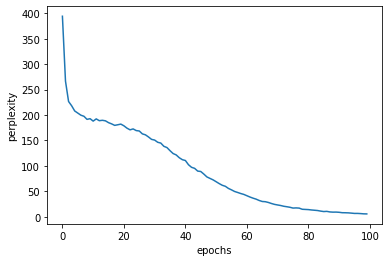

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

그래프를 확인해 보았을 때, 학습을 진행할수록 퍼플레서티가 순조롭게 낮아짐을 알 수 있다. 처음에는 300을 넘던 값이 마지막에는 (최솟값인) 1에 근접한다. 다만 현재의 모델로는 큰 말뭉치에는 전혀 대응할 수 없는 문제가 있는데, 이는 다음 장에서 개선하기로 한다.

## **RNNLM의 Trainer 클래스**

이 책에서는 RNNLM 학습을 수행해주는 RnnlmTrainer 클래스를 제공한다. 이 클래스는 방금 수행한 RNNLM 학습을 클래스 안으로 숨겨준다. 코드의 일부만 발췌하면 다음과 같다.

```
...
from common.trainer import RnnlmTrainer

...
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
```

학습을 수행하는 내부 작업은 다음과 같다.

1. 미니배치를 '순차적'으로 만들어
2. 모델의 순전파와 역전파를 호출하고
3. 옵티마이저로 가중치를 갱신하고
4. 퍼플렉서티를 구한다.

이 책에서는 앞으로 RNNLM 학습에 RnnlmTrainer 클래스를 사용하기로 한다.

# **정리**

* **RNN은 순환하는 경로가 있고, 이를 통해 내부에 '은닉 상태'를 기억할 수 있다.**
* **RNN은 순환 경로를 펼침으로써 다수의 RNN 계층이 연결된 신경망으로 해석할 수 있으며, 보통의 오차역전파법으로 학습할 수 있다(=BPTT).**
* **긴 시계열 데이터를 학습할 때는 데이터를 적당한 길이씩 모으고(이를 '블록'이라 한다), 블록 단위로 BPTT에 의한 학습을 수행한다.(=Truncated BPTT).**
* **Truncated BPTT에서는 역전파의 연결만 끊는다.**
* **Truncated BPTT에서는 순전파의 연결을 유지하기 위해 데이터를 '순차적'으로 입력해야 한다.**
* **언어 모델은 단어 시퀀스를 확률로 해석한다.**
* **RNN 계층을 이용한 조건부 언어 모델은 (이론적으로는) 그때까지 등장한 모든 단어의 정보를 기억할 수 있다.**